# Imports

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

In [22]:
Point = namedtuple('Point', ['x', 'y'])

# Load and convert image to gray scale

In [23]:
def load_and_convert_to_grayscale(image_path):
  original_image = cv2.imread(image_path)

  if original_image is None:
      raise FileNotFoundError(f"Error: Image not found at {image_path}")

  # Convert the image to grayscale
  grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

  # Display the original and grayscale images for verification
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(grayscale_image, cmap='gray')
  plt.title('Grayscale Image')
  plt.axis('off')
  plt.show()
  return grayscale_image

# Create histogram

In [24]:
def create_histogram(usan_image):

    histogram = {}

    for i in range(usan_image.shape[0]):
        for j in range(usan_image.shape[1]):
            value = int(usan_image[i, j])

            if value in histogram:
                histogram[value] += 1
            else:
                histogram[value] = 1

    return histogram

# Susan corner detection

In [25]:
def susan_corner_detection(image, t):

    image = image.astype(np.float64)
    height, width = image.shape

    # Initialize USAN image
    usan_image = np.zeros((height, width))

    # Define 3x3 neighborhood
    radius = 1

    # Loop through each pixel in the image
    # start with radius = 1 for row and column so that we dont get out of bounds and end at height/width-row so that we dont get out of bounds
    for i in range(radius, height - radius):
        for j in range(radius, width - radius):

            # Get nucleus (center pixel) intensity
            nucleus_intensity = image[i, j]
            usan_area = 0

            # Loop through 3x3 neighborhood
            for di in range(-radius, radius + 1):  # -1, 0, 1
                for dj in range(-radius, radius + 1):  # -1, 0, 1

                    neighbor_intensity = image[i + di, j + dj]
                    diff = abs(neighbor_intensity - nucleus_intensity)
                    # comparison function: e^(-((I - I0) / t)^6)
                    comparison = np.exp(-((diff / t) ** 6))
                    usan_area += comparison

            # Store USAN area for this pixel
            usan_image[i, j] = usan_area
    histogram = create_histogram(usan_image)

    return usan_image , histogram

# Visualize susan image

In [26]:
def visualize_usan_image(original_image,usan_image,histogram):

  print("SUSAN CORNER DETECTION RESULTS")
  print("=" * 50)
  print(f"Original image shape: {original_image.shape}")
  print(f"USAN image shape: {usan_image.shape}")
  print(f"USAN value range: [{usan_image.min():.2f}, {usan_image.max():.2f}]")
  print(f"\nHistogram: {histogram}")
  print(f"Total pixels processed: {sum(histogram.values())}")
  print(f"Number of unique values: {len(histogram)}")

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Original image
  axes[0].imshow(original_image, cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  # USAN image
  im = axes[1].imshow(usan_image, cmap='jet')
  axes[1].set_title('USAN Area Map\n(Low=Corners, High=Homogeneous)')
  axes[1].axis('off')
  plt.colorbar(im, ax=axes[1])

  # Histogram
  values = sorted(histogram.keys())
  counts = [histogram[v] for v in values]
  axes[2].bar(values, counts, width=0.8)
  axes[2].set_title('Histogram of USAN Values')
  axes[2].set_xlabel('USAN Value')
  axes[2].set_ylabel('Frequency (Number of Pixels)')
  axes[2].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

# Convex Hull Algorithm

## First step of convex hull where we get points with gradient

In [27]:
def hull_coordinates(histogram):

  keys = sorted(histogram.keys())

  points = []

  # First point
  first_key = keys[0]
  points.append(Point(first_key, histogram[first_key]))

  i_idx = 0
  n = len(keys)

  while i_idx < n - 1:
      i_key = keys[i_idx]
      best_slope = float('-inf')
      best_j_idx = -1

      for j_idx in range(i_idx + 1, n):
          j_key = keys[j_idx]
          slope = (histogram[j_key] - histogram[i_key]) / (j_key - i_key)

          if slope > best_slope:
              best_slope = slope
              best_j_idx = j_idx

      chosen_key = keys[best_j_idx]
      points.append(Point(chosen_key, histogram[chosen_key]))

      i_idx = best_j_idx

  return points


## Returns regions of convex hull

In [28]:
def CalculateHullPoints(histogram):
    points = hull_coordinates(histogram)
    regions = []
    for i in range(len(points)-1):
      region = (points[i],points[i+1])
      regions.append(region)
    return regions

## Visualize the hull histogram


In [29]:
def visualize_convex_hull(histogram):
  t = max(histogram)

  hist_x = histogram.keys()
  hist_y = histogram.values()

  plt.figure(figsize=(10, 5))

  plt.bar(hist_x, hist_y, width=0.1, alpha=0.8, label='Histogram')

  # Hull
  hull_points = hull_coordinates(histogram)
  hull_x = [p.x for p in hull_points]
  hull_y = [p.y for p in hull_points]

  plt.plot(hull_x, hull_y, linewidth=2, color="red", label='Convex Hull')

  plt.xlabel('SUSAN Score')
  plt.ylabel('Frequency')
  plt.title('Histogram and Convex Hull')
  plt.legend()
  plt.show()


## Helper method that takes regios and a point and returns the region that it belongs to

In [30]:
def which_region(regions, x):
    for idx, (start, end) in enumerate(regions):
        if start.x <= x <= end.x:
            return idx
    return -1


## Method that returns hull values accorfing to the regions

In [31]:
def GetHullValues(regions,histogram):
  values = {}
  for key_x, value_y in histogram.items():
    region_idx = which_region(regions,key_x)
    region = regions[region_idx]

    if region_idx == -1:
      continue

    slope = (region[1].y-region[0].y)/(region[1].x-region[0].x)
    c = region[1].y - slope*region[1].x
    values[key_x] = slope*key_x + c
  return values

## Method that returns the threshold = Max(hull[i]-susan_hist[j])

In [32]:
def GetThreshold(histogram, hull_values):
    max_diff = float('-inf')
    threshold = None

    # Sort keys to ensure consistent order (lowest first)
    for key_x in sorted(histogram.keys()):
        key_y = histogram[key_x]
        hv = hull_values.get(key_x)
        if hv is None:
            continue

        diff = abs(hv - key_y)
        if diff > max_diff:
            max_diff = diff
            threshold = key_x

    return threshold


## Splits the histogram according to the threshold

In [33]:
def ApplyThresh(histogram, threshold):
    left_hist = {}
    right_hist = {}

    for key_x, key_y in histogram.items():
        if key_x <= threshold:
            left_hist[key_x] = key_y
        else:
            right_hist[key_x] = key_y

    return left_hist, right_hist


# Draw images

In [34]:
def plot_image(img, title='Image'):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def drawImages(first_threshold, second_threshold, img_array):
    rows, cols = img_array.shape
    below_img    = np.zeros((rows, cols), dtype=np.uint8)
    between_img  = np.zeros((rows, cols), dtype=np.uint8)
    above_img    = np.zeros((rows, cols), dtype=np.uint8)

    for row in range(rows):
        for col in range(cols):
            pixel_value = img_array[row, col]

            if pixel_value <= first_threshold:
                below_img[row, col] = pixel_value
            elif first_threshold < pixel_value <= second_threshold:
                between_img[row, col] = pixel_value
            else:
                above_img[row, col] = pixel_value

    plot_image(img_array, title='Original Given Image')
    plot_image(below_img, title='Pixels Below First Threshold (Corners)')
    plot_image(between_img, title='Pixels Between Thresholds (Edges)')
    plot_image(above_img, title='Pixels Above Second Threshold (Flat Regions)')

In [35]:
def apply_susan_convex_hull(image_path):
  gray_scale_image = load_and_convert_to_grayscale(image_path)
  t = 20
  usan_image, usan_histogram = susan_corner_detection(gray_scale_image, t)
  visualize_usan_image(original_image=gray_scale_image,usan_image=usan_image,histogram=usan_histogram)
  hull_regions = CalculateHullPoints(histogram=usan_histogram)
  print(f"Hull Regions: {hull_regions}")
  visualize_convex_hull(usan_histogram)
  hull_values = GetHullValues(hull_regions,usan_histogram)
  print(f"Hull Values:{hull_values}")
  First_Threshold = GetThreshold(usan_histogram, hull_values)
  print(f"First threshold value: {First_Threshold}")
  below_threshold_hist,above_threshold_hist = ApplyThresh(usan_histogram,First_Threshold)
  hull_regions = CalculateHullPoints(histogram=below_threshold_hist)
  hull_values = GetHullValues(hull_regions,below_threshold_hist)
  Second_Threshold = GetThreshold(below_threshold_hist, hull_values)
  print(f"Second threshold value: {Second_Threshold}")
  drawImages(Second_Threshold, First_Threshold, usan_image)


# Image 1

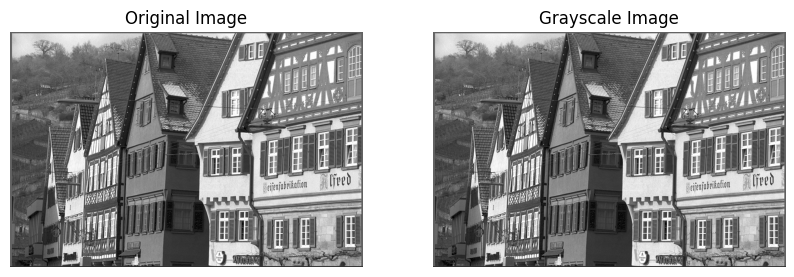

SUSAN CORNER DETECTION RESULTS
Original image shape: (512, 768)
USAN image shape: (512, 768)
USAN value range: [0.00, 9.00]

Histogram: {0: 2556, 9: 1166, 8: 152974, 7: 31593, 6: 35390, 5: 60178, 4: 30794, 3: 34294, 2: 32664, 1: 11607}
Total pixels processed: 393216
Number of unique values: 10


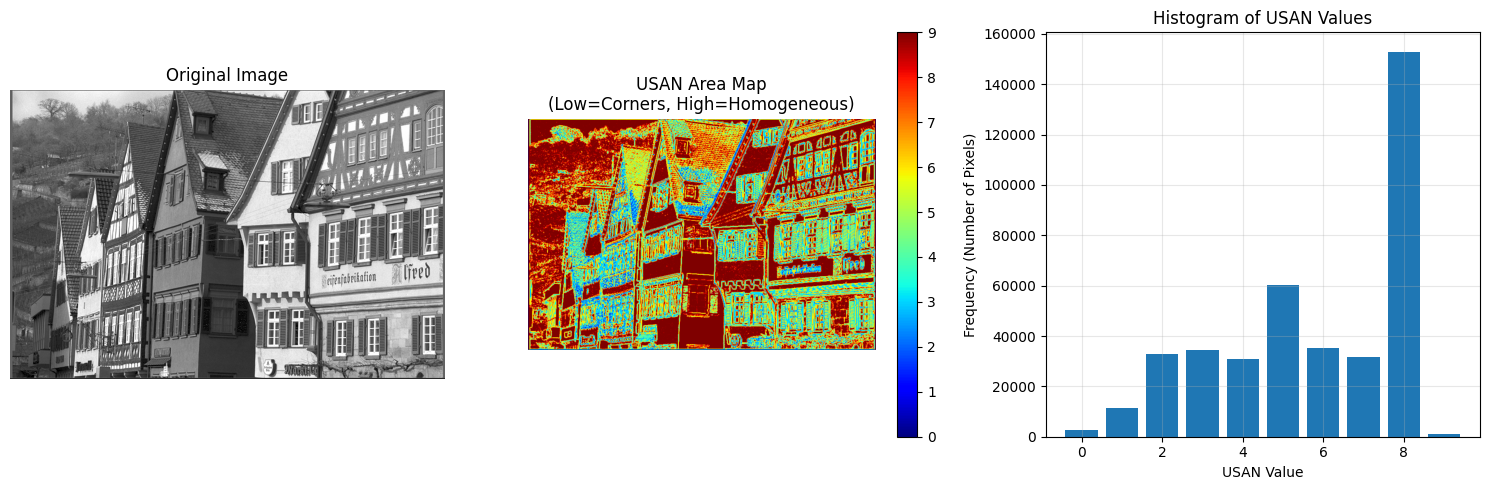

Hull Regions: [(Point(x=0, y=2556), Point(x=8, y=152974)), (Point(x=8, y=152974), Point(x=9, y=1166))]


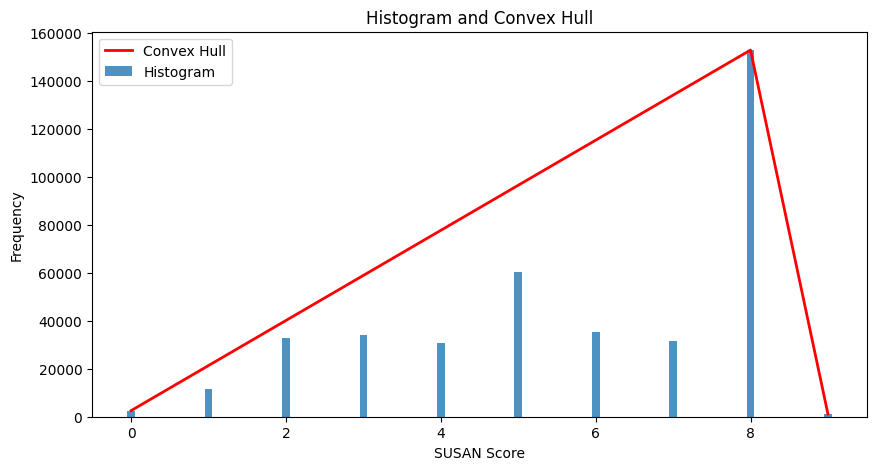

Hull Values:{0: 2556.0, 9: 1166.0, 8: 152974.0, 7: 134171.75, 6: 115369.5, 5: 96567.25, 4: 77765.0, 3: 58962.75, 2: 40160.5, 1: 21358.25}
First threshold value: 7
Second threshold value: 4


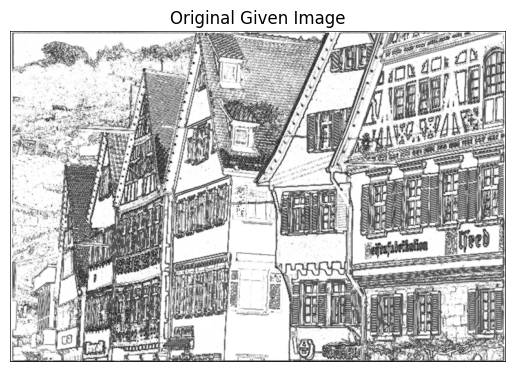

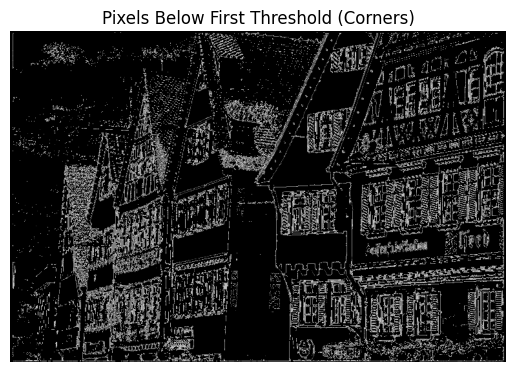

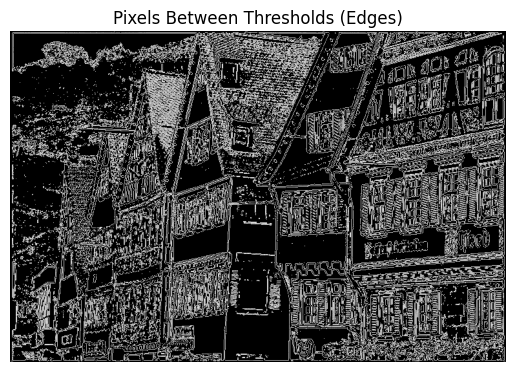

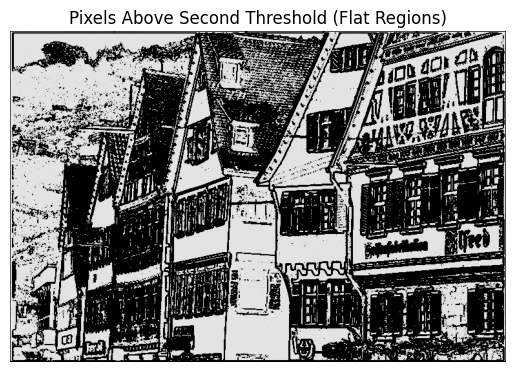

In [36]:
apply_susan_convex_hull('/content/Test Image.png')

# Image 2

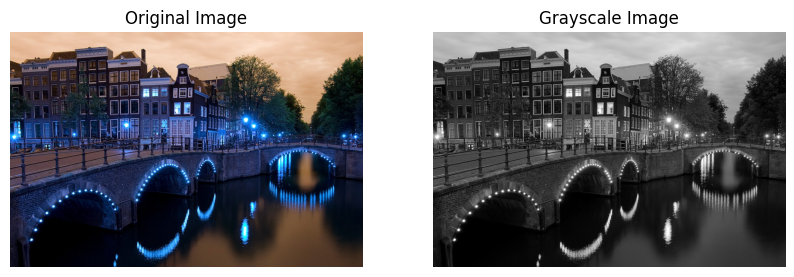

SUSAN CORNER DETECTION RESULTS
Original image shape: (800, 1200)
USAN image shape: (800, 1200)
USAN value range: [0.00, 9.00]

Histogram: {0: 3996, 9: 31242, 8: 565125, 7: 62514, 6: 59356, 5: 74669, 3: 47733, 4: 48962, 1: 18832, 2: 47571}
Total pixels processed: 960000
Number of unique values: 10


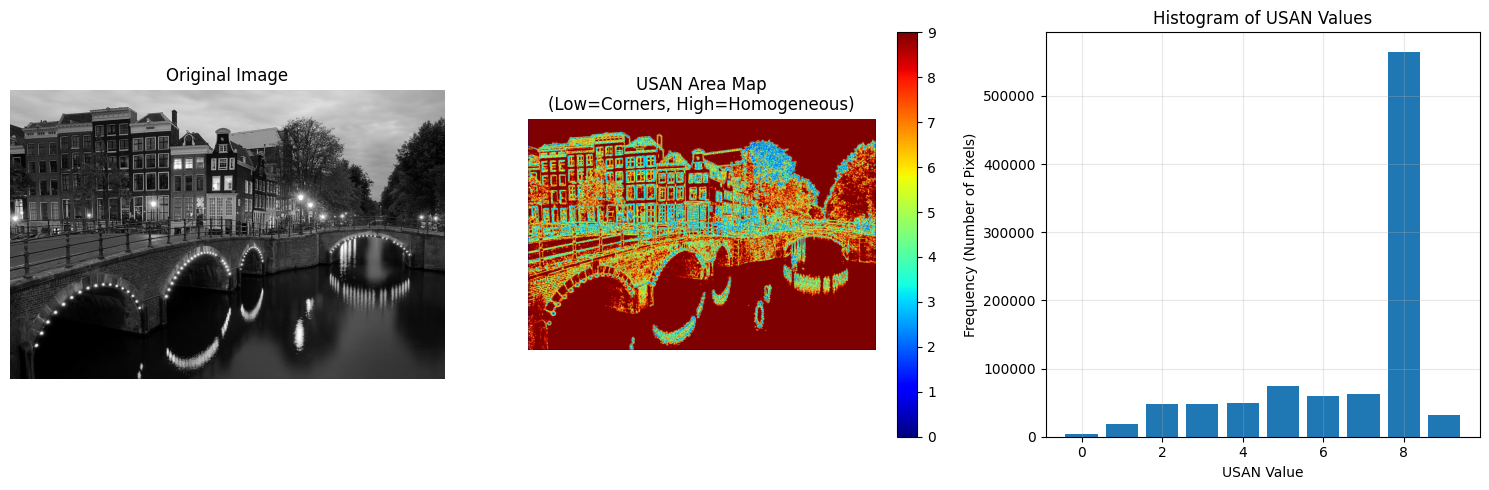

Hull Regions: [(Point(x=0, y=3996), Point(x=8, y=565125)), (Point(x=8, y=565125), Point(x=9, y=31242))]


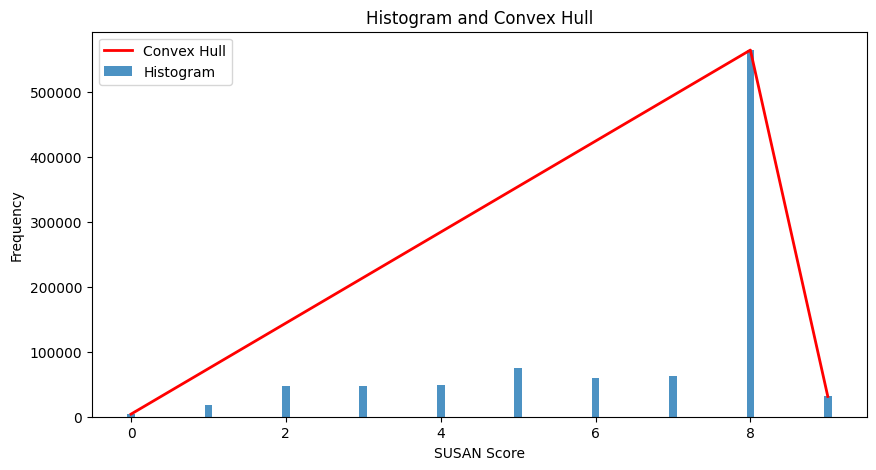

Hull Values:{0: 3996.0, 9: 31242.0, 8: 565125.0, 7: 494983.875, 6: 424842.75, 5: 354701.625, 3: 214419.375, 4: 284560.5, 1: 74137.125, 2: 144278.25}
First threshold value: 7
Second threshold value: 4


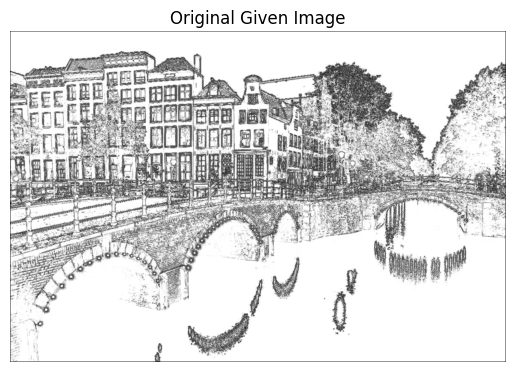

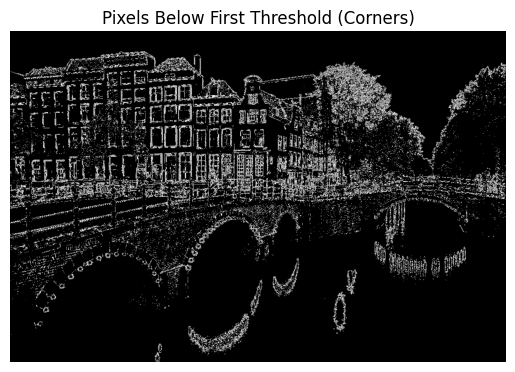

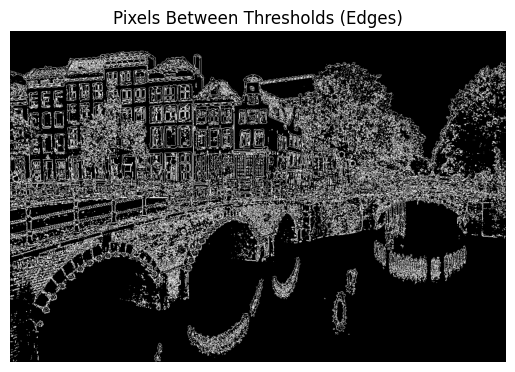

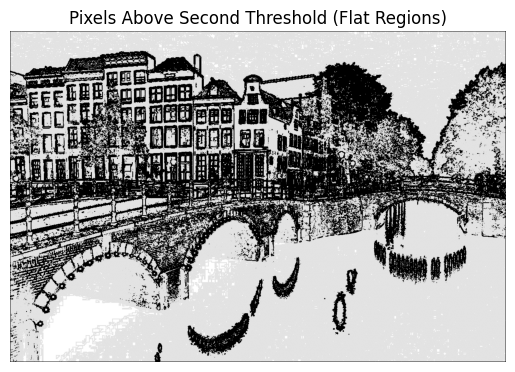

In [37]:
apply_susan_convex_hull('/content/KeizersgrachtReguliersgrachtAmsterdam.jpg')

# Image 3

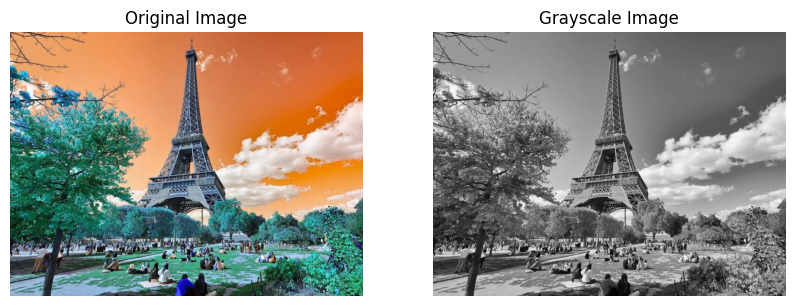

SUSAN CORNER DETECTION RESULTS
Original image shape: (562, 750)
USAN image shape: (562, 750)
USAN value range: [0.00, 9.00]

Histogram: {0: 2620, 4: 37058, 1: 18837, 2: 30328, 3: 35994, 5: 36846, 7: 25728, 8: 159631, 6: 29459, 9: 44999}
Total pixels processed: 421500
Number of unique values: 10


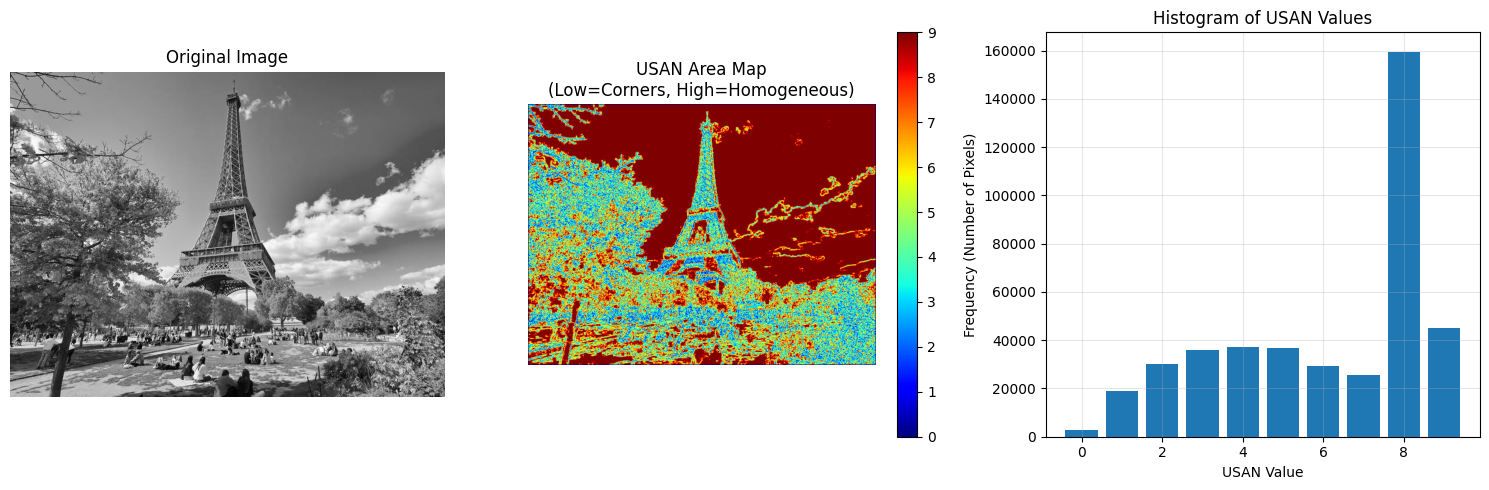

Hull Regions: [(Point(x=0, y=2620), Point(x=8, y=159631)), (Point(x=8, y=159631), Point(x=9, y=44999))]


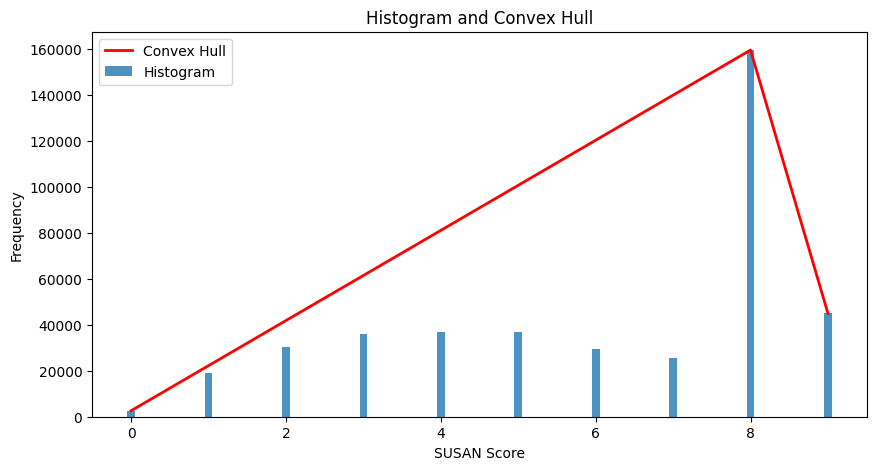

Hull Values:{0: 2620.0, 4: 81125.5, 1: 22246.375, 2: 41872.75, 3: 61499.125, 5: 100751.875, 7: 140004.625, 8: 159631.0, 6: 120378.25, 9: 44999.0}
First threshold value: 7
Second threshold value: 6


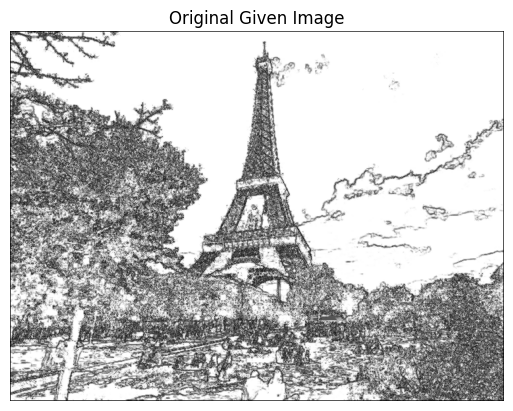

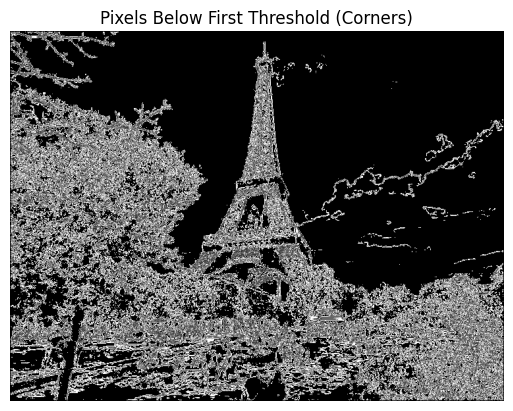

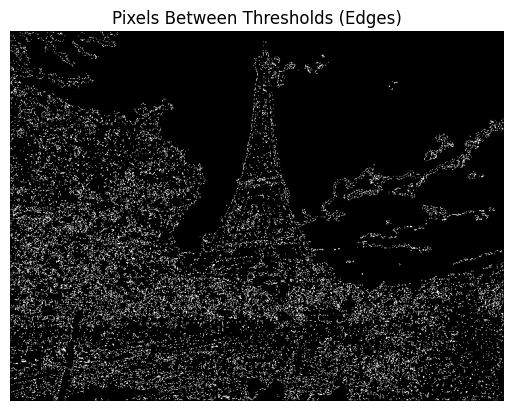

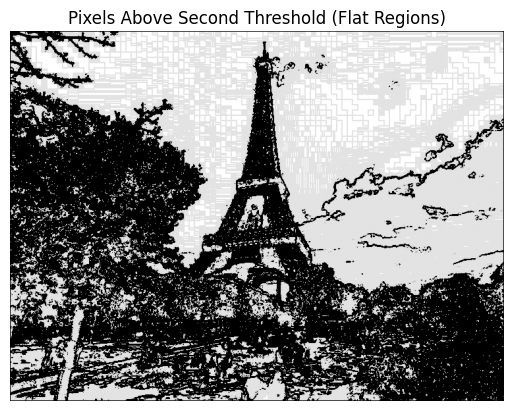

In [38]:
apply_susan_convex_hull('/content/image.jpg')